## CAPP 30254 - Homework 5
#### Fixing/Updating Homework 3
#### Alec MacMillen
#### Due 5/30/2019

The purpose of this homework is to predict predict whether a project on donorschoose will not get fully funded within 60 days of posting. This is a resubmission of the original Homework 3 assignment.

In [1]:
import pipeline as ppl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import model_specs as ms
import ast
import graphviz
from sklearn import linear_model, ensemble, tree, metrics, preprocessing
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 200
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
donors = ppl.load_data("projects_2012_2013.csv")
donors = donors.rename(columns={'total_price_including_optional_support':'total_price'})
meta = ppl.generate_metadata(donors)
summary = ppl.generate_summary(donors)
print("There are", len(donors), "observations of", len(donors.columns), "variables:")
print(meta)
print("-----------------------------------------------------------------------------")
print(summary)

There are 124976 observations of 26 variables:
                              colname                     type  pct_null
0                           projectid            <class 'str'>  0.000000
1                      teacher_acctid            <class 'str'>  0.000000
2                            schoolid            <class 'str'>  0.000000
3                       school_ncesid  <class 'numpy.float64'>  0.073878
4                     school_latitude  <class 'numpy.float64'>  0.000000
5                    school_longitude  <class 'numpy.float64'>  0.000000
6                         school_city            <class 'str'>  0.000000
7                        school_state            <class 'str'>  0.000000
8                        school_metro            <class 'str'>  0.121815
9                     school_district            <class 'str'>  0.001376
10                      school_county            <class 'str'>  0.000000
11                     school_charter            <class 'str'>  0.000000
12  

Let's get some frequency counts of important variables.

In [3]:
for var in ['school_charter', 'school_magnet', 'primary_focus_subject', 'primary_focus_area', 'resource_type', 
            'poverty_level', 'grade_level', 'eligible_double_your_impact_match']:
    print('Frequency counts of', var, ':')
    print(donors[var].value_counts())
    print("-------------------------------")

Frequency counts of school_charter :
f    113340
t     11636
Name: school_charter, dtype: int64
-------------------------------
Frequency counts of school_magnet :
f    114273
t     10703
Name: school_magnet, dtype: int64
-------------------------------
Frequency counts of primary_focus_subject :
Literacy                 37408
Mathematics              16859
Literature & Writing     16141
Special Needs             8348
Visual Arts               5870
Applied Sciences          5825
Environmental Science     4835
Health & Life Science     4185
Music                     3931
History & Geography       2701
Early Development         2618
Character Education       2249
Other                     1809
Performing Arts           1682
ESL                       1604
Social Sciences           1538
Health & Wellness         1450
Gym & Fitness             1281
College & Career Prep     1217
Foreign Languages          898
Sports                     574
Economics                  491
Extracurricular     

These categorical variables are solid candidates for features. *primary_focus_subject* appears to be a more granular category of *primary_focus_area*, so the "area" variable would probably be a more generalizable/flexible feature to use. Let's also do some basic visualization of variable distributions.

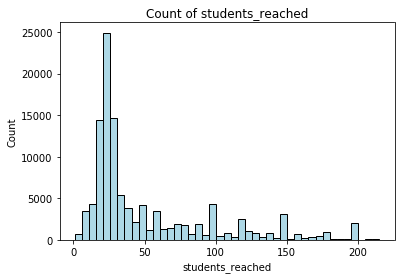

In [4]:
ppl.generate_histogram(donors, 'students_reached', 'lightblue', 5, 'Count of students_reached')

The distribution of *students_reached* has a long right tail, which indicates that we might want to bin the variable more tightly for lower values (say, buckets of 10 up to 50) and then expand bucket size to 50 up until the maximum count of students.

In [5]:
donors['teacher_prefix'].value_counts()

Mrs.    60190
Ms.     48511
Mr.     16273
Dr.         2
Name: teacher_prefix, dtype: int64

It might also be worth exploring whether the teacher's gender has any impact on whether the project gets funded. We would hope this wouldn't be the case, but the potential exists.

In [6]:
price_by_poverty = donors[['poverty_level', 'total_price']]
print("Mean price of project by poverty level")
print(price_by_poverty.groupby(['poverty_level']).mean())
print("-------------------------------------------")
print("Median price of project by poverty level")
print(price_by_poverty.groupby(['poverty_level']).median())
print("-------------------------------------------")

Mean price of project by poverty level
                  total_price
poverty_level                
high poverty       645.553708
highest poverty    638.461452
low poverty        767.358096
moderate poverty   701.941162
-------------------------------------------
Median price of project by poverty level
                  total_price
poverty_level                
high poverty           509.38
highest poverty        505.01
low poverty            570.11
moderate poverty       527.05
-------------------------------------------


Interestingly, the mean *total_price* of a posted project correlates inversely with *poverty_level*: projects in *low_poverty* areas tend to cost over 100 dollars more in *low_poverty* areas as compared to *high_poverty* and *highest_poverty* areas. This effect is somewhat attenuated but still present when looking at the median *total_price*: the median project in *low_poverty* areas is about 65 dollars more expensive than projects in *highest_poverty* areas.

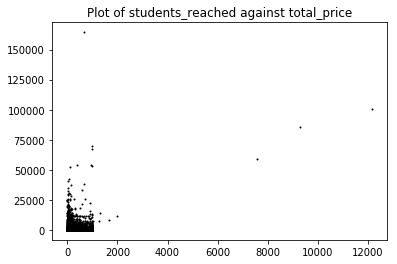

In [7]:
ppl.plot_scatter(donors, 'students_reached', 'total_price', outliers=True)

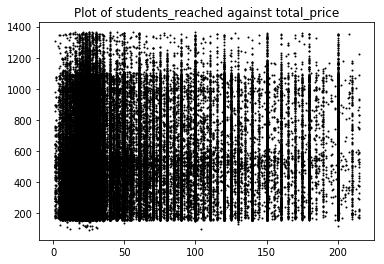

In [8]:
ppl.plot_scatter(donors, 'students_reached', 'total_price', outliers=False)

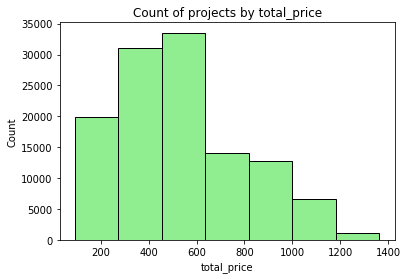

In [9]:
ppl.generate_histogram(donors, 'total_price', 'lightgreen', 200, 'Count of projects by total_price')

There are a few outliers on both the *students_reached* and *total_price* dimensions. Our discretization buckets probably shouldn't go any higher than 1500 for *total_price* or 50 for *students_reached* (before bucket widths expand from a few hundred dollars for *total_price* and 10 or so students for *students_reached*).

The next step is going to be to fill in NA values to fields to be used as features (except for *primary_focus_area* and *resource_type*, because there's no way to "guess" what omitted values of this variable should be classified as - we'll just drop them from the dataset). Then we'll discretize *total_price* and *students_reached*, and to create an indicator variable that takes a value of 1 if a project is fully funded within 60 days of posting and a 0 if not. This variable will be our target.

The next step will be to subset the donors dataset to keep only the most relevant features for analysis. Here is a list of variables we will *drop* with justifications:

- **projectid**, **teacher_acctid**, **schoolid**, **school_ncesid**: these are individual-level data points that uniquely identify a project and provide no useful discerning information about a project that would inform prediction.
- **school_latitude**, **school_longitude**: these numeric fields provide geographic information but at a very granular level. There's no reason to believe the numeric representation of a school's position on the planet would have any predictive power over funding.
- **school_city**, **school_district**, **school_county**: these geographic fields provide extremely specific/granular information about a school and there is too much identifying variation, which could lead to model fitting if included.

The rest of the variables will be preserved.

In [10]:
donors_for_prediction = donors[['school_state', 'school_metro', 'school_charter', 'school_magnet', 'teacher_prefix',
                                'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 
                                'resource_type', 'poverty_level', 'grade_level', 'total_price', 'students_reached', 
                                'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded']]

The next step is to convert *school_charter*, *school_magnet*, and *eligible_double_your_impact_match* to numeric binary variables, and fill all null values of *primary_focus_area* and *resource_type* to "Unknown" (this step can take place before the train-test split, because values are being filled uniformly). We will also generate a *not_funded_within_60_days* variable that takes a value of 1 if the time to funding completion exceeds 60 days, and 0 if otherwise. This will be the target variable for prediction.

In [11]:
donors_for_prediction['school_charter'] = np.where(donors_for_prediction['school_charter'] == 't', 1, 0)
donors_for_prediction['school_magnet'] = np.where(donors_for_prediction['school_magnet'] == 't', 1, 0)
donors_for_prediction['eligible_double_your_impact_match'] = np.where(donors_for_prediction['eligible_double_your_impact_match'] == 't', 1, 0)

donors_for_prediction['datefullyfunded'] = pd.to_datetime(donors_for_prediction['datefullyfunded'])
donors_for_prediction['date_posted'] = pd.to_datetime(donors_for_prediction['date_posted'])
donors_for_prediction['timedelta'] = (donors_for_prediction['datefullyfunded'] - donors_for_prediction['date_posted']).dt.days
donors_for_prediction['not_funded_within_60_days'] = np.where(donors_for_prediction['timedelta'] > 60, 1, 0)

In [12]:
donors_for_prediction = donors_for_prediction.drop(columns=['datefullyfunded','timedelta'])

These are the features we'll proceed with for prediction. In a future extension of this analysis, we might augment our dataset with census data for demographic information for the school district/county/city.

For our next step, let's create the 3 sets of train-test data, based on 6-month rolling windows in the 24-month data we have available, leaving a 60-day gap (the length of the validation period) between each training and testing set:
- **Set 1**: train 1/1/2012-4/30/2012; test 7/1/2012-12/31/2012
- **Set 2**: train 1/1/2012-10/31/2012; test 1/1/2013-6/30/2013
- **Set 3**: train 1/1/2012-4/30/2013; test 7/1/2013-12/31/2013

These train-test splits assume that we are evaluating test data after 2/1/2014.

In [13]:
feature_list = ['school_state', 'school_metro', 'school_charter', 'school_magnet',
                'teacher_prefix', 'primary_focus_subject', 'primary_focus_area',
                'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
                'poverty_level', 'grade_level', 'total_price', 'students_reached',
                'eligible_double_your_impact_match']

x_train1, x_test1, y_train1, y_test1 = ppl.create_date_splits_manual(
    donors_for_prediction, feature_list, 'not_funded_within_60_days', 'date_posted', 
    ('01/01/2012', '04/30/2012'), ('07/01/2012', '12/31/2012'))

x_train2, x_test2, y_train2, y_test2 = ppl.create_date_splits_manual(
    donors_for_prediction, feature_list, 'not_funded_within_60_days', 'date_posted', 
    ('01/01/2012', '10/31/2012'), ('1/01/2013', '06/30/2013'))

x_train3, x_test3, y_train3, y_test3 = ppl.create_date_splits_manual(
    donors_for_prediction, feature_list, 'not_funded_within_60_days', 'date_posted', 
    ('01/01/2012', '04/30/2013'), ('07/01/2013', '12/31/2013'))

Let's also make an authoritative list of all categorical columns that we *should* observe as features in all train/test datasets. If there is a category that doesn't appear in a given slice of data (i.e. one of the train or test sets), we will need to explicitly add this column with all zeros to make sure the data is the correct dimension and has all information necessary.

In [14]:
categorical_cols = ['school_state', 'school_metro', 'teacher_prefix', 'primary_focus_subject',
                   'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
                   'resource_type', 'poverty_level', 'grade_level']
continuous_cols = ['total_price', 'students_reached']

In [15]:
all_categorical = ppl.dummify_categorical(donors_for_prediction, categorical_cols)
all_categorical_cols = list(all_categorical.columns)[8:]

Now, for all of our x (feature) datasets, we'll impute missing values, scale continuous variables, and convert categorical variables to dummies. This functionality is contained in the "prepare_dfs" function found in the pipeline module.

In [16]:
x_train1_pr = ppl.prepare_dfs(x_train1, categorical_cols, continuous_cols, all_categorical_cols)
x_test1_pr = ppl.prepare_dfs(x_test1, categorical_cols, continuous_cols, all_categorical_cols)
x_train2_pr = ppl.prepare_dfs(x_train2, categorical_cols, continuous_cols, all_categorical_cols)
x_test2_pr = ppl.prepare_dfs(x_test2, categorical_cols, continuous_cols, all_categorical_cols)
x_train3_pr = ppl.prepare_dfs(x_train3, categorical_cols, continuous_cols, all_categorical_cols)
x_test3_pr = ppl.prepare_dfs(x_test3, categorical_cols, continuous_cols, all_categorical_cols)

Finally, we will convert the feature datasets to arrays so they are in the correct form to be passed to models for fitting, and perform a sanity check to make sure they are all in the correct shape.

In [17]:
x_train1a, x_test1a = ppl.convert_to_array(x_train1_pr, x_test1_pr)
x_train2a, x_test2a = ppl.convert_to_array(x_train2_pr, x_test2_pr)
x_train3a, x_test3a = ppl.convert_to_array(x_train3_pr, x_test3_pr)

print("Set 1train:", x_train1a.shape, y_train1.shape)
print("Set 1test:", x_test1a.shape, y_test1.shape)
print("Set 2train:", x_train2a.shape, y_train2.shape)
print("Set 2test:", x_test2a.shape, y_test2.shape)
print("Set 3train:", x_train3a.shape, y_train3.shape)
print("Set 3test:", x_test3a.shape, y_test3.shape)

Set 1train: (21176, 152) (21176,)
Set 1test: (32838, 152) (32838,)
Set 2train: (49676, 152) (49676,)
Set 2test: (21530, 152) (21530,)
Set 3train: (74184, 152) (74184,)
Set 3test: (44167, 152) (44167,)


Now, feed the train/test sets to the model loop and let all run to create summary of best model by performance. We will prioritize precision as a metric to minimize false positives, as we can only intervene with the top 5% of projects.

In [18]:
summary_df_1 = ppl.run_all_models(x_train1a, y_train1, x_test1a, y_test1, 
                                 '01/01/2012-04/30/2012', '07/01/2012-12/31/2012',
                                 'not_funded_within_60_days', ms.model_list, 'precision')

summary_df_2 = ppl.run_all_models(x_train2a, y_train2, x_test2a, y_test2, 
                                 '01/01/2012-10/31/2012', '01/01/2013-06/30/2013',
                                 'not_funded_within_60_days', ms.model_list, 'precision')

summary_df_3 = ppl.run_all_models(x_train3a, y_train3, x_test3a, y_test3, 
                                 '01/01/2012-04/30/2013', '07/01/2013-12/31/2013',
                                 'not_funded_within_60_days', ms.model_list, 'precision')

#### Top 5 performing models by precision at 0.05 threshold

In [19]:
summary_df_1[summary_df_1['threshold']==0.05].head(5)

,Unnamed: 0,model,train_date,test_date,parameters,threshold,baseline,accuracy,precision,recall,f1,auc
715,114,Random forest,01/01/2012-04/30/2012,07/01/2012-12/31/2012,"{'n_estimators': 50, 'max_depth': 3, 'criterio...",0.05,0.743072,0.735063,0.419866,0.081664,0.136733,0.521325
716,219,Random forest,01/01/2012-04/30/2012,07/01/2012-12/31/2012,"{'n_estimators': 100, 'max_depth': 5, 'criteri...",0.05,0.743072,0.734271,0.411944,0.080123,0.134154,0.520288
717,121,Random forest,01/01/2012-04/30/2012,07/01/2012-12/31/2012,"{'n_estimators': 50, 'max_depth': 3, 'criterio...",0.05,0.743072,0.734149,0.410725,0.079886,0.133757,0.520128
719,198,Random forest,01/01/2012-04/30/2012,07/01/2012-12/31/2012,"{'n_estimators': 100, 'max_depth': 3, 'criteri...",0.05,0.743072,0.733784,0.407069,0.079175,0.132566,0.519650
718,212,Random forest,01/01/2012-04/30/2012,07/01/2012-12/31/2012,"{'n_estimators': 100, 'max_depth': 5, 'criteri...",0.05,0.743072,0.733784,0.407069,0.079175,0.132566,0.519650


In [20]:
summary_df_2[summary_df_2['threshold']==0.05].head(5)

,model,train_date,test_date,parameters,threshold,baseline,accuracy,precision,recall,f1,auc
438,Logistic regression,01/01/2012-10/31/2012,01/01/2013-06/30/2013,"{'penalty': 'l1', 'C': 0.5}",0.05,0.685183,0.694937,0.597584,0.094866,0.163738,0.532757
439,Logistic regression,01/01/2012-10/31/2012,01/01/2013-06/30/2013,"{'penalty': 'l1', 'C': 0.75}",0.05,0.685183,0.694566,0.593866,0.094276,0.162720,0.532326
440,Logistic regression,01/01/2012-10/31/2012,01/01/2013-06/30/2013,"{'penalty': 'l1', 'C': 1.0}",0.05,0.685183,0.694287,0.591078,0.093833,0.161956,0.532003
448,Gradient boosting,01/01/2012-10/31/2012,01/01/2013-06/30/2013,"{'n_estimators': 200, 'max_depth': 3, 'loss': ...",0.05,0.685183,0.691129,0.559480,0.088817,0.153298,0.528343
449,Logistic regression,01/01/2012-10/31/2012,01/01/2013-06/30/2013,"{'penalty': 'l2', 'C': 0.75}",0.05,0.685183,0.690943,0.557621,0.088522,0.152788,0.528127


In [21]:
summary_df_3[summary_df_3['threshold']==0.05].head(5)

,model,train_date,test_date,parameters,threshold,baseline,accuracy,precision,recall,f1,auc
382,Random forest,01/01/2012-04/30/2013,07/01/2013-12/31/2013,"{'max_depth': 10, 'n_estimators': 100, 'random...",0.05,0.715353,0.713225,0.478714,0.084076,0.143031,0.523823
383,Random forest,01/01/2012-04/30/2013,07/01/2013-12/31/2013,"{'max_depth': 2, 'n_estimators': 100, 'random_...",0.05,0.715353,0.712998,0.476449,0.083678,0.142355,0.523545
384,Random forest,01/01/2012-04/30/2013,07/01/2013-12/31/2013,"{'max_depth': 10, 'n_estimators': 100, 'random...",0.05,0.715353,0.712998,0.476449,0.083678,0.142355,0.523545
385,Random forest,01/01/2012-04/30/2013,07/01/2013-12/31/2013,"{'max_depth': 3, 'n_estimators': 100, 'random_...",0.05,0.715353,0.712863,0.475091,0.083439,0.141949,0.523378
386,Random forest,01/01/2012-04/30/2013,07/01/2013-12/31/2013,"{'max_depth': 5, 'n_estimators': 100, 'random_...",0.05,0.715353,0.712817,0.474638,0.083360,0.141813,0.523323


Interestingly, it appears that random forests perform best at the 0.05 threshold for train/test sets 1 (train 1/1/12-4/30/12, test 7/1/12-12/31/12) and 3 (train 1/1/12-4/30/13, test 7/1/13-12/31/13). On the other hand, logistic regression and gradient boosting perform best at the 0.05 threshold for train/test set 2 (train 1/1/12-10/31/12, test 1/1/13-6/30/13).

### Visualizing Model Results
#### Train/test period 1

Let's now take the best-performing model, by precision, in each train/test split and visualize results. It's important to note that the threshold of each of these models is 0.5, which implies our chosen intervention is relatively inexpensive and easy to apply to a large number of potentially underfunded projects. 

In [22]:
threshold_p1 = summary_df_1[summary_df_1['threshold']==0.05]
p1_best_specs = threshold_p1.iloc[0]
p1_model = ensemble.RandomForestClassifier(**ast.literal_eval(p1_best_specs['parameters']))
p1_model.fit(x_train1a, y_train1)
pred_scores = p1_model.predict_proba(x_test1a)
actual, predicted = ppl.get_pred_and_actual(x_test1a, y_test1, 'not_funded_within_60_days', pred_scores, 0.5)

Normalized confusion matrix
[[ 0.54801033  0.45198967]
 [ 0.36114733  0.63885267]]


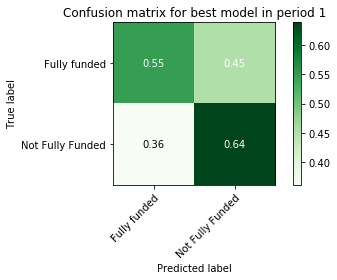

In [23]:
ppl.plot_confusion_matrix(actual, predicted, ['Fully funded','Not Fully Funded'],
                         normalize=True, title="Confusion matrix for best model in period 1")

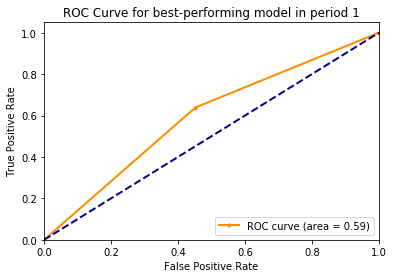

In [24]:
fpr, tpr, _ = metrics.roc_curve(actual, predicted)
roc_auc = metrics.auc(fpr, tpr)
ppl.plot_roc_curve(fpr, tpr, roc_auc, 'darkorange', 'ROC Curve for best-performing model in period 1')

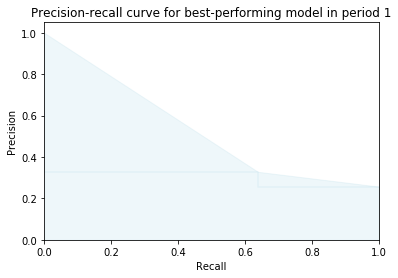

In [25]:
precision, recall, _ = metrics.precision_recall_curve(actual, predicted)
plt.step(recall, precision, color='lightblue', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='lightblue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-recall curve for best-performing model in period 1")
plt.show()

#### Train/test period 2

In [26]:
threshold_p2 = summary_df_2[summary_df_2['threshold']==0.05]
p2_best_specs = threshold_p2.iloc[0]
p2_model = linear_model.LogisticRegression(**ast.literal_eval(p2_best_specs['parameters']))
p2_model.fit(x_train2a, y_train2)
pred_scores = p2_model.predict_proba(x_test2a)
actual, predicted = ppl.get_pred_and_actual(x_test2a, y_test2, 'not_funded_within_60_days', pred_scores, 0.5)

Normalized confusion matrix
[[ 0.5727359   0.4272641 ]
 [ 0.34169371  0.65830629]]


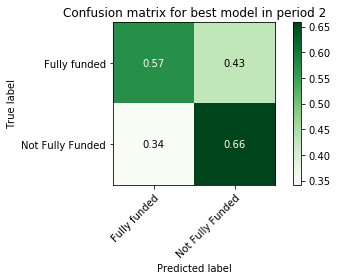

In [27]:
ppl.plot_confusion_matrix(actual, predicted, ['Fully funded','Not Fully Funded'],
                         normalize=True, title="Confusion matrix for best model in period 2")

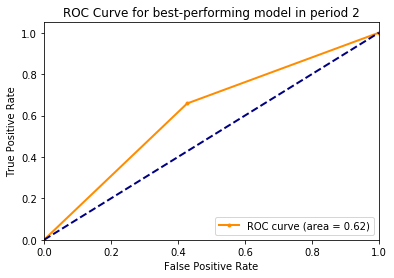

In [28]:
fpr, tpr, _ = metrics.roc_curve(actual, predicted)
roc_auc = metrics.auc(fpr, tpr)
ppl.plot_roc_curve(fpr, tpr, roc_auc, 'darkorange', 'ROC Curve for best-performing model in period 2')

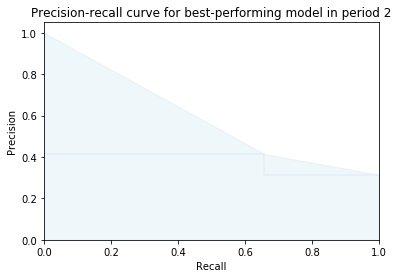

In [29]:
precision, recall, _ = metrics.precision_recall_curve(actual, predicted)
plt.step(recall, precision, color='lightblue', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='lightblue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-recall curve for best-performing model in period 2")
plt.show()

#### Train/test period 3

In [30]:
threshold_p3 = summary_df_3[summary_df_3['threshold']==0.05]
p3_best_specs = threshold_p3.iloc[0]
p3_model = ensemble.RandomForestClassifier(**ast.literal_eval(p3_best_specs['parameters']))
p3_model.fit(x_train3a, y_train3)
pred_scores = p3_model.predict_proba(x_test3a)
actual, predicted = ppl.get_pred_and_actual(x_test3a, y_test3, 'not_funded_within_60_days', pred_scores, 0.5)

Normalized confusion matrix
[[ 0.56936224  0.43063776]
 [ 0.32572383  0.67427617]]


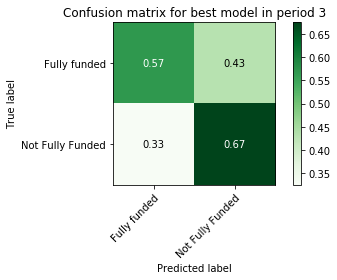

In [31]:
ppl.plot_confusion_matrix(actual, predicted, ['Fully funded','Not Fully Funded'],
                         normalize=True, title="Confusion matrix for best model in period 3")

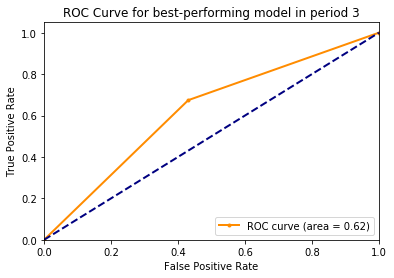

In [32]:
fpr, tpr, _ = metrics.roc_curve(actual, predicted)
roc_auc = metrics.auc(fpr, tpr)
ppl.plot_roc_curve(fpr, tpr, roc_auc, 'darkorange', 'ROC Curve for best-performing model in period 3')

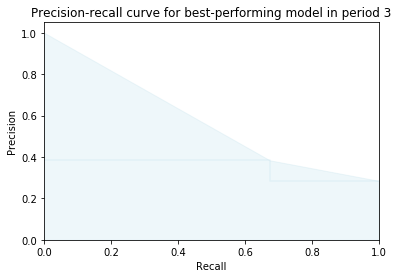

In [33]:
precision, recall, _ = metrics.precision_recall_curve(actual, predicted)
plt.step(recall, precision, color='lightblue', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='lightblue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-recall curve for best-performing model in period 3")
plt.show()